<center>
    <h1 id='content-based-filtering' style='color:#7159c1; font-size:350%'>Content-Based Filtering</h1>
    <i style='font-size:125%'>Recommendations of Similar Items by Plot Description</i>
</center>

> **Topics**

```
- ✨ Content-Based Filtering
- ✨ Word Cloud
- ✨ Cosine Similarity
- ✨ Bag of Words
- ✨ Token and N-Grams
- ✨ Stemming and Lemmatization
- ✨ Stop Words
- ✨ ZIPF's Law
- ✨ Term Frequency - Inverse Document Frequency (TF-IDF)
- ✨ Hands-on
```

In [29]:
# ---- Imports ----
import matplotlib.pyplot as plt             # pip install matplotlib
import mplcyberpunk                         # pip install mplcyberpunk
import numpy as np                          # pip install numpy
import pandas as pd                         # pip install pandas
import seaborn as sns                       # pip install seaborn
from sklearn.feature_extraction.text import TfidfVectorizer  # pip install sklearn
from sklearn.metrics.pairwise import linear_kernel           # pip install sklearn
import string                               # pip install string
from wordcloud import WordCloud             # pip install wordcloud

# ---- Pre-Trained Models ----
#
# pip install -U pip setuptools wheel
# pip install -U spacy
# python -m spacy download en_core_web_sm >> efficiency (English Model)
# python -m spacy download en_core_web_trf >> accuracy (English Model)
#
import spacy
spacy_english_efficiency_model = spacy.load("en_core_web_sm")

# ---- Constants ----
DATASETS_PATH = ('./datasets')
SEED = (20231223)

# ---- Settings ----
np.random.seed(SEED)
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
plt.style.use('cyberpunk')

# ---- Functions ----
def transform_synopsis(synopsis):
    """
    \ Description:
        - transforms a string into Spacy Document;
        - creates a list containing all non-stop words' lemma from the document;
        - returns the list words concatenated.
    
    \ Parameters:
        - synopsis: string.
    """
    document = spacy_english_efficiency_model(synopsis)
    transformed_text = [token.lemma_ for token in document if not token.is_stop and token.pos_ != 'PROPN']
    return ' '.join(transformed_text)

def transform_duplicated_titles(duplicated_titles_list):
    """
    \ Description:
        - passes through each element from the parameter;
        
        - if title is into 'title_count' element:
            - 'title_count' is increased by 1 for the current title;
            - current title is updated by adding a number to the end;
            - the number addition starts from 2, that is, from the first repetition of the current title.
            
        - if title is not into 'title_count':
            - title is inserted into 'title_count' with count equals to 1;
            - the current title is returned as is;
    
    \ Parameters:
        - duplicated_titles_list: list of strings.
    """
    title_count = {}
    result = []

    for title in duplicated_titles_list:
        if title in title_count:
            title_count[title] += 1
            result.append(f'{title} {title_count[title]}')
        else:
            title_count[title] = 1
            result.append(title)
    return result

def get_recommendations(dataset, title, animes_indices, cosine_similarity, number_recommendations=10):
    """
    \ Description:
        - gets the index of the anime that matches the title;
        - gets the pairwise similarity scores of all animes with the chosen anime;
        - sort the animes based on the similarity socres on descending order;
        - gets the scores of the top 'number_recommendations' animes, excluding the chosen one;
        - gets the animes indices;
        - returns the animes indices.
    
    \ Parameters:
        - dataset: Pandas DataFrame;
        - title: string;
        - animes_indices: list of integers;
        - cosine_similarity: NumPy array of floats;
        - number_recommendation: integer.
    """
    index = animes_indices[title]
    
    similarity_scores = list(enumerate(cosine_similarity[index]))
    similarity_scores = sorted(similarity_scores, key=lambda score: score[1], reverse=True)
    similarity_scores = similarity_scores[1:number_recommendations+1]
    
    recommended_animes_indices = [index[0] for index in similarity_scores]
    return dataset.title.iloc[recommended_animes_indices]

<h1 id='0-content-based-filtering' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Content-Based Filtering</h1>

`Content-Based Filtering` recommends animes that are similar to other animes that a user liked. If you use Netflix, you probably already stumbled upon to some series marked as `Because you added ...`. If that's so, congrats, that is a real-world Content-Based Filtering Recommendation!! To make things even clearer, assume that a user liked Dragon Ball Z on a stream platform and it uses Content-Based Filtering to recommend the animes. Guess what? The platform will probably recommend Dragon Ball Super or Naruto to the very user, because both animes are similar to Dragon Ball Z, that is, both animes are shounen with superpowers.

Besides, this Filtering has two modes: 1) `Plot Description Based`, where the synopsis and/or overview are used to identify similar items; and 2) `Metadata Based`, where information about genres, producers, studios, format and so on are used to identify similar items.

About the advantages:

> **Better Recommendations** - `since it recommends different animes to the users accordingly to similar animes watched by them, it makes better recommendations when compared to Demographic Filtering`;

> **Personalized Recommendations** - `each user receives personalized recommendations accordingly to the animes they watched`;

> **Variation of Metrics** - `since there are more than one evaluation metric available, the model can be improved just by replacing the metric`.

<br />

Disadvantages-wise:

> **More Data Required** - `in order to recommend similar items, more detailed data about the animes are needed`;

> **Only Sequels and Prequels Recommendations** - `when dealing with Plot Description Based, there is a high probability to get only sequels and prequels recommendations, since they have a very similar synopsis`;

> **Bubble of Contents** - `when dealing with Metadata Based, there is a high probability to create a Bubble that only recommends animes with an especific genre and topic`.

<br />

The image below ilustrates how this technique works:

<br />

<figure style='text-align:center'>
    <img style='border-radius:20px' src='./assets/1-content-based-filtering.png' alt='Content-Based Filtering Diagram' />
    <figcaption>Figure 1 - Content-Based Filtering Diagram. By <a href='https://medium.com/mlearning-ai/content-based-recommender-system-using-nlp-445ebb777c7a'>Arif Zainurrohman - Content-Based Recommender System Using NLP©</a>.</figcaption>
</figure>

<br /><br />

In this notebook, we are going to dive into Plot Description Based technnique and consider Cosine Similarity as the Evaluation Metric.

<h1 id='1-word-cloud' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Word Cloud</h1>

`Word Cloud` is a great technique to stand out the most frequent terms from Sequential Texts. In a simplier way, it shows the most frequent words from a bunch of texts.

Since we are dealing with Plot Description Based mode, let's plot the Word Cloud of Animes Synopsis.

In [19]:
# ---- Reading Dataset ----
animes_df = pd.read_csv(f'{DATASETS_PATH}/anime-transformed-dataset-2023.csv', index_col='id')[['title', 'score', 'synopsis']]

# ---- Removing Animes without Synopsis ----
animes_df = animes_df.loc[animes_df.synopsis != '-']

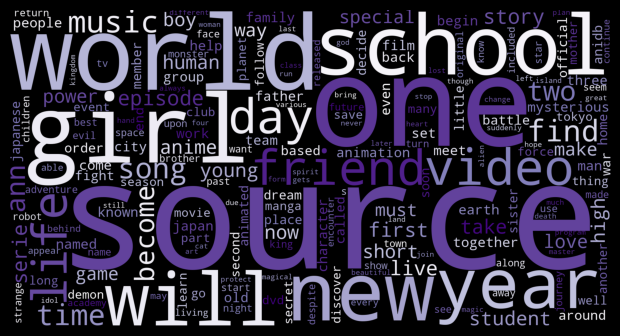

In [20]:
# ---- Plotting Word Cloud ----
synopsis_text = ' '.join(animes_df.synopsis)

synopsis_word_cloud = WordCloud(
    collocations=False # only considedr words as unigrams, example, 'Dragon Ball' is considered as two words: 'Dragon' and 'Ball'
    , background_color='black'
    , colormap='Purples'
    , width=2048
    , height=1080
    , random_state=SEED
).generate(synopsis_text)

plt.figure(facecolor='k')
plt.imshow(synopsis_word_cloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

The bigger the word font, the more frequent the word is on animes' synopsis. Thus, we can conclude most of synopsis contains words like `world, one, source, girl, school, will, new, year, time...`.

Nonetheless, even though Word Clouds are very useful getting an overview about the words frequencies, it is not appropriate on recommendation models. On these ones, we have to use more refined techniques to find similar items. For now, let's explain about the chosen Evaluation Metric: `Cosine Similarity`.

<h1 id='2-cosine-similarity' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Cosine Similarity</h1>

`Cosine Similarity` is a perfect metric to measure the similarity between two values of a same feature, especially when dealing with sequential texts. In a nutshell, it works dividing the sum of the multiplication of the frequency of the elements in each items by the product of the squared root of the quadratic appearance of each element into the items 🤯😶‍🌫️. You can be wondering: *What the hell did I just read?*. Do not worry, The example below makes everything clear 🤣

Consider these two sentences: `Hello World!` (sentence A) and `Hello!` (sentence B). The first thing to do is to create a table showing the frequency of each word in each sentence:

<table style='border-style: solid'>
    <caption>Frequency Table of Each Word in Each Sentence</caption>
    <tr align='center' style='border-style: solid'>
        <th style='border-style: solid'>Word</th>
        <th style='border-style: solid'># in A</th>
        <th style='border-style: solid'># in B</th>
    </tr>
    <tr align='center'>
        <td style='border-style: solid'><b>Hello</b></td>
        <td style='border-style: solid'>1</td>
        <td style='border-style: solid'>1</td>
    </tr>
    <tr align='center'>
        <td style='border-style: solid'><b>World</b></td>
        <td style='border-style: solid'>1</td>
        <td style='border-style: solid'>0</td>
    </tr>
</table>

After that, we: 

- plot the frequencies using points;
- trace two lines across the points, one line for each point; 
- calculate the angle between the lines;
- calculate the cosine of the angle;
- the cosine of the angle is the Cosine Similarity Score. It goes from 0 (completely not similar) to 1 (completely similar).

In this example, the angle between the lines is `45º` and its cosine is `0.71`, thus we can tell that both sentences are 71% similar. The image below ilustrates the plot and the calculation:

<br />

<figure style='text-align:center'>
    <img style='border-radius:20px' src='./assets/3-cosine-similarity-statquest.png' alt='Cosine Similarity of the Example' />
    <figcaption style='text-align: center'>Figure 2 - Cosine Similarity calculation of sentences in the example. By <a href='https://www.youtube.com/watch?v=e9U0QAFbfLI'>StatQuest with Josh Starmer - Cosine Similarity, Clearly Explained!!!©</a>, at 03:34 minutes.</figcaption>
</figure>

<br /><br />

Quite simple and easy to catch, isn't it? You can check out a better explanation about this topic accessing the StatQuest YouTube video here: [StatQuest with Josh Starmer - Cosine Similarity, Clearly Explained!!!](https://www.youtube.com/watch?v=e9U0QAFbfLI).

Just one more thing, the frequency does not have influence in the similarity, only the presence or not presence have influence. It means that the sentences `Hello!` and `Hello! Hello! Hello!` have the same Cosine Similarity to `Hello World!`, since the angle between the lines is still 45º. The image below ilustrates it:

<br />

<figure style='text-align:center'>
    <img style='border-radius:20px' src='./assets/4-cosine-similarity-statquest.png' alt='Cosine Similarity of the Example' />
    <figcaption style='text-align: center'>Figure 3 - Cosine Similarity calculation of the new example. By <a href='https://www.youtube.com/watch?v=e9U0QAFbfLI'>StatQuest with Josh Starmer - Cosine Similarity, Clearly Explained!!!©</a>, at 04:24 minutes.</figcaption>
</figure>

<br /><br />

When dealing with only two words, there is no problem, we can plot it using two axis: x-axis and y-axis. When dealing with three words, there is no problem too, we can plot it adding a third axis: z-axis. But, with four or more words, this task becomes tough, because we have no idea how to plot four and more dimensional plots. A simple synopsis can have more than a 100 words. Can you imagine how a 100 dimensional plot would look like? I am sure that even the Scientists have no clue about it.

Fortunately, we can replace the plot task by applying the Cosine Similarity Equation given below:

```python
sum(A[i] * B[i]) / (sqrt(sum(A[i]**2)) * sqrt(sum(B[i]**2)))
```

<br />

$$
Cosine Similarity = \frac{\sum_{i=1}^{n} (A[i] \cdot B[i] \cdot C[i])} {\sqrt{\sum_{i=1}^{n} (A[i]^2)} \cdot \sqrt{\sum_{i=1}^{n} (B[i]^2)} \cdot \sqrt{\sum_{i=1}^{n} (C[i]^2)}}
$$

<br />

where:

- A, B and C: items;
- n: number of different elements into the items;
- A[i]: number of times the element "i" is present into item A;
- B[i]: number of times the element "i" is present into item B;
- C[i]: number of times the element "i" is present into item C;
- [...];
- N[i]: number of times the element "i" is present into item N.

<h1 id='3-bag-of-words' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Bag of Words</h1>

Before applying Cosine Similarity, we first have to create the `Bag of Words`, that is, group all synopsis words together. So, assuming the sentence `Dragon Ball Series is a peak show!` is an anime synopsis, its Bag of Words would look like this:

```python
synopsis = ['Dragon Ball Series is a peak show!']
bag_of_words = ['dragon', 'ball', 'series', 'is', 'a', 'peak', 'show']
```

Realize that, in this especific example, each word is an element of a list and, if duplicated words are present, the term would appear only once. Besides, it is a best practice removing all punctuations - commas, question marks, exclamation marks and so on - and to lower casing all texts.

<h1 id='4-token-and-n-grams' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ |Token and N-Grams</h1>

We have seem earlier that each word is an element of the Bag of Words for that especific example, but there are many of situations that the element can be a combination of n-words or even only a partial slice of the word.

Thus, before creating the Bag of Words, we have to define the `Tokens` pattern. Tokens are, literatelly, the proper given name for Bag of Words elements in Natural Language Processing (NLP).

Tokens patterns are called `N-Grams`, where each gram identify how many terms compose the token. The main patterns are `Unigram, Bigram and Trigram`, being:

<br />

> **Unigram** - `token is composed by a single word`;

> **Bigram** - `token is composed by a combination of two words`;

> **Trigram** - `token is composed by a combination of three words`.

<br />

So, for `Dragon Ball Series is a peak show!` synopsis, the Bag of Words would look like this for each pattern:


```python
unigram = ['dragon', 'ball', 'series', 'is', 'a', 'peak', 'show']
bigram = ['dragon ball', 'ball series', 'series is', 'is a', 'a peak', 'peak show']
trigram = ['dragon ball series', 'ball series is', 'series is a', 'is a peak', 'a peak show']
```

<h1 id='5-stemming-and-lemmatization' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Stemming and Lemmatization</h1>

In order to reduce the size of Bag of Words, techniques can applied in order to reduce words and consequently, resulting in many words being replaced by a single reduction, a smaller Bag and a smaller computational cost and time over Cosine Similarity calculations. The main techniques of this kind are `Stemming` and `Lemmatization` .

`Stemming` is a way to reduce words to their stem - if you remember your English classes on school, you will probably remember the contents about Stemming too -. For example, the words 'programming', 'programmer', and 'programs' can all be reduced down to the common word stem 'program'. In a nutshell, these three words can be represented by only one: 'program'.

Advantages:

> **Smaller Bag of Words** - `it reduces the number of unique words into the Bag of Words and, consequently, the computational cost and time to calculate the Cosine Similarity`;

> **Grouping Similar Words** - `since many words have the same stem, they can be replaced by a single common word`;

> **Easy to Understand** - `word stems are easier to understand when compared to word lemmas`.

<br />

Disadvantages-wise:

> **Overstemming or False Positives** - `words with complete different meanings can have the same stem and, consequently, they will be replaced by a single word and interpreted as synonym. For instance, 'universal', 'university' and 'universe' stem is 'univers', even thoug having complete different meanings`;

> **Understemming of False Negatives** - `in the other hand, words with similar meanings can have different stem and, consequently, they will be replaced by different words and not interpreted as synonyms. For instance, 'alumnus', 'alumnae' and 'alumni' does not have the same stem, even though having similar meanings`;

> **Language Challenges** - `the stemming logic changes for each language, taking the morphology, spelling and character encoding into consideration and, conseequently, demanding more sofisticated algorithms and computations costs`.

<br />

`Lemmatization` is an alternative for Stemming that, instead of reducing words to their stems, it reduces them to their lemma (dictionary form). Also, it takes the word meaning in the whole sentence and context into consideration to reduce it. For example, 'runs', 'running', and 'ran' would be reduced to their dictionary form 'run'.

Advantages:

> **Accuracy** - `since it takes the word meaning in the whole sentence and context, the reductions are more accurate for recommendation models`.

<br />

Disadvantages-wise:

> **Hard to Understand** - `word lemmas are harder to understand when compared to word stems`;

> **Computational Cost and Time** - `compared to Stemming, Lemmatization is a slow and time-consuming process due to its morphological analysis and word meaning derivation from its dictionary form`.

<br />

We are going to apply Lemmatization in both notebooks about Content-Based Filtering!!

<h1 id='6-stop-words' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Stop Words</h1>

On 'Dragon Ball Series is a peak show!' sentence, the word 'a' does not give so much information about the sentence context, that is, if we remove it, the sentence meaning and context would remain the same.

These words that do not affect the sentence meaning and context at all are known as `Stop Words` and they are commonly discarded from Bag of Words and Word Vectors due to their tendency to give noise to the data.

Thus, our earlier Bag of Words would look like this after dropping its Stop Words:

```python
previous_bag_of_words = ['dragon', 'ball', 'series', 'is', 'a', 'peak', 'show']
current_bag_of_words = ['dragon', 'ball', 'series', 'is', 'peak', 'show']
```

<h1 id='7-zipfs-law' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | ZIPF's Law</h1>

`ZIPF's Law` tells that some things have high frequency and are popular, whereas others does not have high frequencies and are not popular neither, and there is a pattern that shows their frequency and popularity.

For our animes synopsis scenario, some words appear a lot of times in different synopsis, so, consequently, they have high frequencies and are popular; in the other side of the coin, some words have low frequencies and are unpopular. Accordingly to ZIPF's Law, the most common word appears around twice as often as the second most common word, three times as often as the third one, and so on.

In order to apply this Law for Sequential Texts, we have to use `Term Frequency - Inverse Document Frequency` technique.

<h1 id='8-term-frequency-inverse-document-frequency-tf-idf' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Term Frequency - Inverse Document Frequency (TF-IDF)</h1>

`Term Frequency - Inverse Document Frequency (TF-IDF)` applies ZIPF's Law on texts affirming that the word importance for a text is influenced by two things:

<br />

> **The Word Frequency in the Text** - `the more frequent the word is, the higher is its importance for the text`;

> **The Word Frequency in other Texts** - `the more texts the word appears, the lower is its importance for an especific text`.

<br />

Let's dive into a simple example about the usage of TF-IDF where we want to measure the 'fox' word importance in the following two sentences:

- A quick brown fox jumps over a lazy dog. What a fox!

- A quick brown fox jumps over a lazy fox. What a fox!

Steps:

1. Calculate the Term Frequency (TF) of 'fox' for each document. The idea is to divide the word frequency by the total number of words in the document:

$$
\text{TF('fox', first_sentence)} = \frac{2}{12} = 0.17
$$

$$
\text{TF('fox', second_sentence)} = \frac{3}{12} = 0.25
$$

<br />

2. Calculate the Inverse Document Frequency (IDF) of 'fox' in the whole set of documents. The IDF is a constant for each word in the whole document and it is given by calculating the log of the total number of documents divided by the number of documents that contain the word. The log base can be any value, being 2, 10 and e the most common ones. For this example, let's consider 10 as the log base:

$$
\text{IDF('fox', all_documents)} = \log_{10} \frac{2}{2} = 0
$$

3. Calculate the Term Frequency - Inverse Document Frequency (TF-IDF) of 'fox' for each sentence. The TF-IDF is calculated by multiplying the TF by the IDF value:

$$
\text{TF-IDF('fox', first_sentence)} = TF \cdot IDF = 0.17 \cdot 0 = 0
$$

$$
\text{TF-IDF('fox', second_sentence)} = TF \cdot IDF = 0.25 \cdot 0 = 0
$$

4. Get the 'fox' importance for the sentences. Since the TF-IDF for the word in both sentences is zero, 'fox' is not so much important to differentiate both sentences!! Besides, considering that the TF-IDF value is the same for both sentences, 'fox' is equally relevant for both documents.

<br />

The image below illustrates the example:

<figure style='text-align:center'>
    <img style='border-radius:20px' src='./assets/15-tf-idf.png' alt='Calculation of TF-IDF of two sentences' />
    <figcaption style='text-align: center'>Figure 4 - Calculation of TF-IDF of two sentences. By <a href='https://www.youtube.com/watch?v=vZAXpvHhQow'>
Data Science Garage - Calculate TF-IDF in NLP (Simple Example)©</a>, at 07:14 minutes.</figcaption>
</figure>

<br /> <br />

<h1 id='9-hands-on' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Hands-on</h1>

Now that we have all required knowledgments, let's go to the hands-on and create a Recommendation Model using Content-Based Filtering for Plot Description logic. Here, we are going to follow nine steps:

1. lower case all synopsis;
2. remove all break lines characters (\n) and other special characters (\t \r \x0b \x0c) replacing them by spaces;
3. remove all punctuations;
4. remove all Stop Words;
5. apply Lemmatization;
6. calculate Term Frequency - Inverse Document Frequency with unigrams as tokens pattern;
7. calculate Cosine Similarity;
8. deal with duplicated titles;
9. create a search function to find the ten most similar animes for a given anime.

---

**- Lower Casing, Removing All Break Lines, Removing All Special Characters and Removing All Punctuations**

In [21]:
# ---- Lower Casing ----
animes_df.synopsis = animes_df.synopsis.apply(lambda synopsis: synopsis.lower())

# ---- Removing All Break Lines (\n) and Special Characters (\t \t \x0b \x0c)
animes_df.synopsis = animes_df.synopsis.apply(lambda synopsis: ' '.join(synopsis.split()))

# Removing All Punctuations ----
#
# - 'replace' method: replaces a character by another one;
# - 'translate' method: replaces a buch of characters by a single one;
# - 'str.maketrans' method parameters:
#    \ third parameter: characters to be replaced;
#    \ first parameter: characters that will replace the third parameter;
#    \ second parameter: characters that will replace the first parameter.
#
animes_df.synopsis = animes_df.synopsis.apply(lambda synopsis: synopsis.translate(str.maketrans('', '', string.punctuation)))

---

**- Removing Stop Words and Lemmatizating**

In [22]:
# ---- Removing Stop Words and Lemmatizating ----
animes_df['transformed_synopsis'] = animes_df.synopsis.apply(lambda synopsis: transform_synopsis(synopsis))
animes_df.head()

,title,score,synopsis,transformed_synopsis
id,,,,
1,cowboy bebop,8.75,crime is timeless by the year 2071 humanity ha...,crime timeless year 2071 humanity expand galax...
5,cowboy bebop tengoku no tobira,8.38,another day another bounty—such is the life of...,day bounty — life unlucky crew bebop routine i...
6,trigun,8.22,vash the stampede is the man with a 6000000000...,vash stampede man 60000000000 bounty head reas...
7,witch hunter robin,7.25,robin sena is a powerful craft user drafted in...,powerful craft user draft stnj — group special...
8,bouken ou beet,6.94,it is the dark century and the people are suff...,dark century people suffer rule devil vandel a...


---

**- Calculating Term Frequency - Inverse Document Frequency (TF-IDF)**

`Analyzer` parameter defines the token n-gram pattern, being `unigram (word)` the chosen one.

`Norm` parameter defines the values normalization, where `l2` makes the sum of the squares of vector elements be equals to 1, and `l1` makes the sum of the absolute values of vector elements be equals to 1. For the model, `l2` is the chosen normalization.

Also, we are going to apply stop words remotion again in order to really assure that all stop words gotten removed.

In [23]:
# ---- Calculating TF-IDF ----
tfidf_vectorizer = TfidfVectorizer(analyzer='word', norm='l2', stop_words='english')
tfidf_synopsis = tfidf_vectorizer.fit_transform(animes_df.transformed_synopsis)

print(f'- Number of Animes: {tfidf_synopsis.shape[0]}')
print(f'- Number of Words to Describe the Animes: {tfidf_synopsis.shape[1]}')

- Number of Animes: 19892
- Number of Words to Describe the Animes: 38019


---

**- Calculating Cosine Similarity**

When `l2` is the chosen normalization for TF-IDF, the Cosine Similarity can be calculated by squaring the TF-IDF results (see [sklearn.feature_extraction.text.TfidfVectorizer - Norm Parameter](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). In order to do it efficiently, requiring less computational time and cost, we are going to use sklearn metrics.

About the metrics, we have two options: `Cosine Similarity (sklearn.metrics.pairwise.cosine_similarity)` and `Linear Kernel (sklearn.metrics.pairwise.linear_kernel)`. Since the second one is way faster than the first, we are going on with it.

In [24]:
# ---- Calculating Cosine Similarity ----
cosine_similarity_synopsis = linear_kernel(tfidf_synopsis, tfidf_synopsis)

---

**- Dealing with Duplicated Titles**

In [25]:
# ---- Dealing with Duplicated Titles: Getting Duplicated Titles List ----
duplicated_title_indexes = animes_df.title.duplicated(keep=False)
duplicated_titles_list = transform_duplicated_titles(
    animes_df[duplicated_title_indexes].sort_values(by='title', ascending=True).title.to_list()
)

In [26]:
# ---- Dealing with Duplicated Titles: Transforming the Titles ----
duplicated_animes_df = animes_df[duplicated_title_indexes].sort_values(by='title', ascending=True)
duplicated_animes_df['title'] = duplicated_titles_list
animes_df.loc[duplicated_title_indexes] = duplicated_animes_df
animes_df.loc[duplicated_title_indexes].sort_values(by='title', ascending=True)

,title,score,synopsis,transformed_synopsis
id,,,,
39783,5-toubun no hanayome,8.08,through their tutor fuutarou uesugis diligent ...,tutor fuutarou uesugis guidance quintuplet aca...
38101,5-toubun no hanayome 2,7.66,fuutarou uesugi is an ace high school student ...,ace high school student lead tough life stando...
38328,azur lane,6.28,when the sirens an alien force with an arsenal...,siren alien force arsenal far surpass limit cu...
55351,azur lane 2,-1.00,assorted commercials for the azur lane mobile ...,assorted commercial game post official youtube...
48610,blue reflection ray,5.70,miniseries for blue reflection ray with superd...,miniserie blue reflection ray superdeforme cha...
...,...,...,...,...
48365,youkai watch 3,6.21,the new show will feature unique and returning...,new feature unique return yokai comedy center ...
12403,yuru yuri,7.82,the girls of the amusement club return in yuru...,girl amusement club return ♪ find new way pass...
10495,yuru yuri 2,7.57,after a year in grade school without her child...,year grade school childhood friend year studen...


---

**- Creating Search Function**

In [27]:
# ---- Recommending Animes: Reseting Animes Dataframe Index ----
#
# - in order to the index follow a sequence from 0 to 'n', being 'n'
# the total number of animes.
#
animes_df.reset_index(inplace=True)

In [51]:
# ---- Recommending Animes ----
#
# - search aniems titles that contains a given string in order to use it
# in the next cell to get recommendations.
#
animes_df.title.loc[animes_df.title.str.contains('steins')]

5604                                           steins gate
6303                  steins gate oukoubakko no poriomania
6450              steins gate movie fuka ryouiki no d j vu
9398       steins gate soumei eichi no cognitive computing
10232                                        steins gate 0
10890    steins gate kyoukaimenjou no missing link - di...
13693    steins gate 0 kesshou takei no valentine - bit...
Name: title, dtype: object

In [52]:
# ---- Recommending Animes ----
animes_indices = pd.Series(animes_df.index, index=animes_df.title)
get_recommendations('steins gate', animes_indices, cosine_similarity_synopsis, 10)

6303                  steins gate oukoubakko no poriomania
10890    steins gate kyoukaimenjou no missing link - di...
6450              steins gate movie fuka ryouiki no d j vu
10232                                        steins gate 0
15204                                konohakaseki no natsu
13550                              moshimoshi, terumi desu
18530                                      duoyun shi qing
9398       steins gate soumei eichi no cognitive computing
8302                               mou hitotsu no mirai wo
5702                            katsugeki shoujo tanteidan
Name: title, dtype: object

Realize that Content-Based Filtering by Plot Descriptions usually recommends sequels and prequels of the same anime first. Even though it is good for those who watched and liked the show, it can bore the users since there is a chance to they only receive recommendations about the same anime universe. For instance, try replacing 'steins gate' by 'dragon ball z' or 'naruto', almost all recommendations will be sequels and prequels of the same anime.

---

<h1 id='reach-me' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>📫 | Reach Me</h1>

> **Email** - [csfelix08@gmail.com](mailto:csfelix08@gmail.com?)

> **Linkedin** - [linkedin.com/in/csfelix/](https://www.linkedin.com/in/csfelix/)

> **GitHub:** - [CSFelix](https://github.com/CSFelix)

> **Kaggle** - [DSFelix](https://www.kaggle.com/dsfelix)

> **Portfolio** - [CSFelix.io](https://csfelix.github.io/).